# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [75]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

response = requests.get(url, headers=headers)

if response.status_code == 200: 
    html_content = response.text
else:
    print("Error al acceder a la pagina", response.status_code)

html_content


'\r\n<!DOCTYPE html>\r\n<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\r\n<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->\r\n<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->\r\n<!--[if gt IE 8]><!--> <html class="no-js"> <!--<![endif]-->\r\n    <head>\r\n        <meta charset="utf-8">\r\n        <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\r\n\t\t<link rel="canonical" href="https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue" />\r\n\t\t<link rel="alternate" media="only screen and (max-width: 768px)" href="https://m.macrotrends.net/stocks/charts/TSLA/tesla/revenue">\r\n\t\t<title>Tesla Revenue 2010-2024 | TSLA | MacroTrends</title>\r\n\t\t<link rel="icon" type="image/x-icon" href="/assets/images/icons/FAVICON/macrotrends-favicon-96.png">\r\n\t\t<meta name="description" content="Tesla annual/quarterly revenue history and growth rate from 2010 to 2024. Revenue can be defined as the amount of mo

In [65]:
soup = BeautifulSoup(html_content, 'html.parser')

all_tables = soup.find_all("table")
all_tables

[<table class="historical_data_table table">
 <thead>
 <tr>
 <th colspan="2" style="text-align:center">Tesla Annual Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td style="text-align:center">2023</td>
 <td style="text-align:center">$96,773</td>
 </tr>
 <tr>
 <td style="text-align:center">2022</td>
 <td style="text-align:center">$81,462</td>
 </tr>
 <tr>
 <td style="text-align:center">2021</td>
 <td style="text-align:center">$53,823</td>
 </tr>
 <tr>
 <td style="text-align:center">2020</td>
 <td style="text-align:center">$31,536</td>
 </tr>
 <tr>
 <td style="text-align:center">2019</td>
 <td style="text-align:center">$24,578</td>
 </tr>
 <tr>
 <td style="text-align:center">2018</td>
 <td style="text-align:center">$21,461</td>
 </tr>
 <tr>
 <td style="text-align:center">2017</td>
 <td style="text-align:center">$11,759</td>
 </tr>
 <tr>
 <td style="text-align:center">2016</td>
 <td style="text-align:center">$7,000</td>
 </tr>
 <

In [66]:
for idx, table in enumerate(all_tables):
    if "Tesla Quarterly Revenue" in str(table):
        table_evolution = table
        break

if table_evolution:
    tesla_revenue = pd.DataFrame(columns=["date", "revenue"])
    
    for row in table_evolution.find_all("tr")[1:]:
        cols = row.find_all("td")
        if cols:
            date = cols[0].text.strip()
            revenue = cols[1].text.strip().replace("$", "").replace(",", "")

            tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
                "date": [date],
                "revenue": [revenue]
            })], ignore_index=True)
    print(tesla_revenue.head())

else:
    print("Table not found Tesla Quarterly Revenue.")
    

         date revenue
0  2024-06-30   25500
1  2024-03-31   21301
2  2023-12-31   25167
3  2023-09-30   23350
4  2023-06-30   24927


In [67]:
conn = sqlite3.connect('Tesla.db')
conn

cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS REVENUE (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        revenue REAL
    )
''')

In [68]:
for index, row in tesla_revenue.iterrows():
    cursor.execute("INSERT INTO REVENUE (date, revenue) VALUES (?, ?)", (row['date'], row['revenue']))

conn.commit()

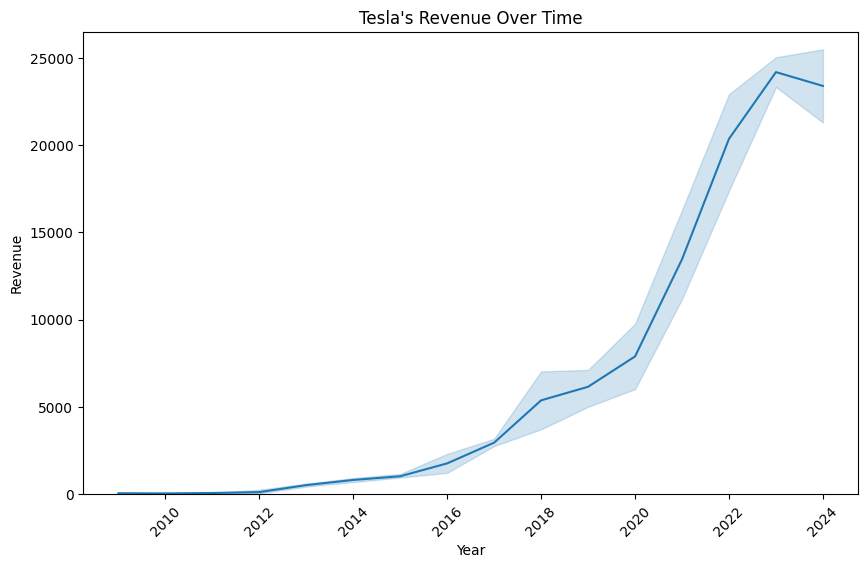

In [79]:
tesla_revenue['year'] = pd.to_datetime(tesla_revenue['date']).dt.year
tesla_revenue['revenue'] = pd.to_numeric(tesla_revenue['revenue'], errors='coerce')
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='revenue', data=tesla_revenue)
plt.title("Tesla's Revenue Over Time")
plt.xticks(rotation=45)
plt.ylabel('Revenue')
plt.xlabel('Year')
plt.ylim(0, tesla_revenue['revenue'].max() + 1000)
plt.show()

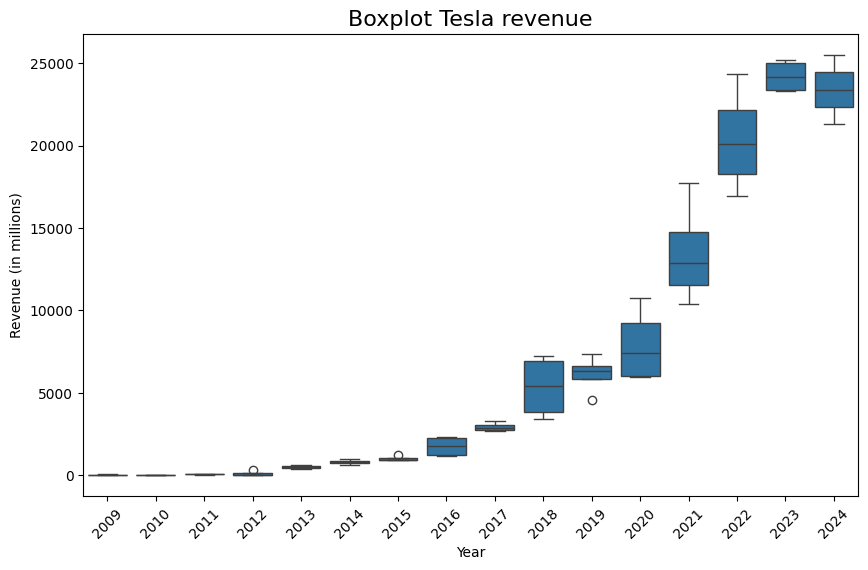

In [80]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='revenue', data=tesla_revenue)
plt.title('Boxplot Tesla revenue', fontsize=16)
plt.xticks(rotation=45) 
plt.ylabel('Revenue (in millions)')
plt.xlabel('Year')
plt.show()

/tmp/ipykernel_984/1649649725.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='revenue', data=tesla_revenue, palette='coolwarm')


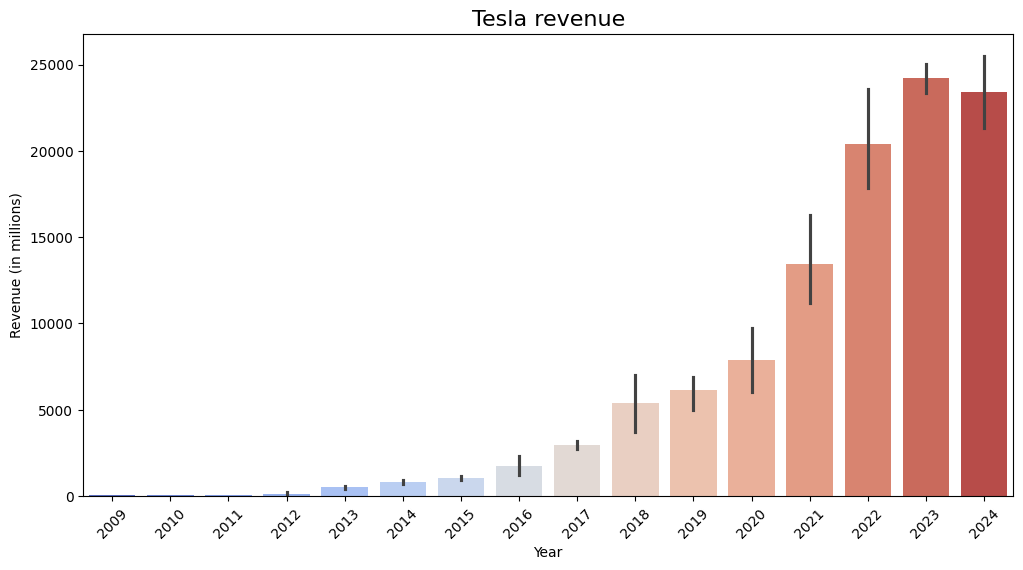

In [81]:
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='revenue', data=tesla_revenue, palette='coolwarm')
plt.title('Tesla revenue', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Revenue (in millions)')
plt.xlabel('Year')
plt.show()
